In [1]:
import importdata
import MachineLearning as ML
import MLAnalysis as MLA
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = importdata.importdata(slice(None,100000))

In [3]:
data.columns.values

array(['RELEASE', 'OBJID', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR',
       'EBV', 'FLUX_U', 'FLUX_G', 'FLUX_R', 'FLUX_I', 'FLUX_Z', 'FLUX_Y',
       'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_U',
       'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_I', 'FLUX_IVAR_Z',
       'FLUX_IVAR_Y', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3',
       'FLUX_IVAR_W4', 'MW_TRANSMISSION_U', 'MW_TRANSMISSION_G',
       'MW_TRANSMISSION_R', 'MW_TRANSMISSION_I', 'MW_TRANSMISSION_Z',
       'MW_TRANSMISSION_Y', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2',
       'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 'NOBS_U', 'NOBS_G',
       'NOBS_R', 'NOBS_I', 'NOBS_Z', 'NOBS_Y', 'NOBS_W1', 'NOBS_W2',
       'NOBS_W3', 'NOBS_W4', 'RCHISQ_U', 'RCHISQ_G', 'RCHISQ_R',
       'RCHISQ_I', 'RCHISQ_Z', 'RCHISQ_Y', 'RCHISQ_W1', 'RCHISQ_W2',
       'RCHISQ_W3', 'RCHISQ_W4', 'FRACFLUX_U', 'FRACFLUX_G', 'FRACFLUX_R',
       'FRACFLUX_I', 'FRACFLUX_Z', 'FRACFLUX_Y', 'FRACFLUX_W1',
       'FRACFLUX_W2', 'FRACFLUX_

In [5]:
def random_forest(input_names, target_name):
    inputs, target = data[input_names], data[target_name]
    reg = ML.Regressors(inputs, target)
    prediction, truth = reg.RFregressor()
    return prediction, truth

In [6]:
input_names = ["gmag", "rmag", "zmag", "w1mag", "w2mag"]
target_name = "redshift"

In [7]:
prediction, truth = random_forest(input_names, target_name)

/home/alan/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alan/mega/AstroTechniques/margaret/notebooks/MachineLearning.py:56: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  self._scaled_X = scaler.transform(self._X)


In [38]:
reload(MLA)

<module 'MLAnalysis' from '/home/alan/mega/AstroTechniques/margaret/notebooks/MLAnalysis.py'>

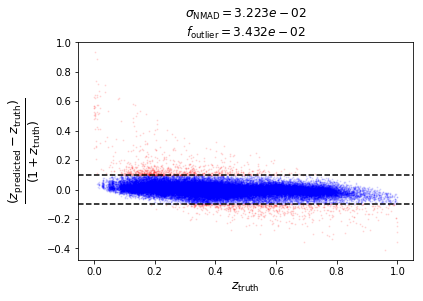

In [42]:
f = lambda z: z + 1  # optional
analysis = MLA.RegressionAnalyzer(prediction, truth, scale_as=f)

target_label = "z"  # optional
f_label = lambda target: f"(1 + {target})"  # optional
analysis.plot_residuals(target_label=target_label, f_label=f_label,
                        outlier_sigmas=3, spread_estimator="nmad", fontsize=14*1./1.5)
plt.show()

In [56]:
z_predict_rf, z_true_rf = random_forest(input_names, target_name)

/home/alan/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alan/mega/AstroTechniques/margaret/notebooks/MachineLearning.py:56: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  self._scaled_X = scaler.transform(self._X)


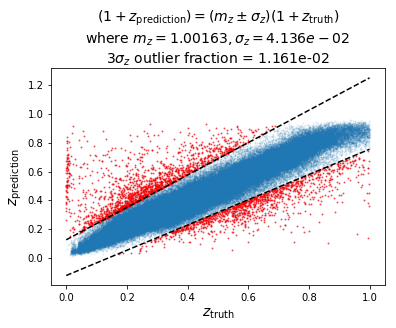

In [87]:
scatter_target(z_predict_rf, z_true_rf)

In [22]:
input_names = ["gmag", "gminr", "rminz", "zminw1", "w1minw2"]
z_predict, z_true = random_forest(input_names, target_name)

/home/alan/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alan/mega/AstroTechniques/margaret/notebooks/MachineLearning.py:56: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  self._scaled_X = scaler.transform(self._X)


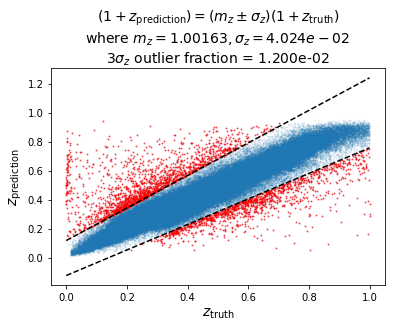

In [88]:
scatter_target(z_predict, z_true)

In [89]:
def scale_as(prediction, truth):
    return prediction/(1+truth)

def scale_inv(prediction, truth):
    return (1+truth)*prediction

def scale_as_string(prediction_or_truth):
    # Math mode is implied
    return f"\\frac{{z_{{{prediction_or_truth}}}}}{{1 + z{{\\rm truth}}}}"
    #return f"\\frac{{{prediction_string}}}{{1 + {truth_string}}}"

def scatter_target(prediction, truth, target_string="z", scale_as=scale_as, scale_inv=scale_inv, 
                   scale_as_string=scale_as_string, outlier_sigmas=3):
    slope,sigma = slope_mean_sigma(prediction, truth, scale_as)
    upper = slope + outlier_sigmas*sigma
    lower = slope - outlier_sigmas*sigma
    x = np.linspace(truth.min(),truth.max(),2)
    plt.plot(x, scale_inv(upper*scale_as(x)), "k--")
    plt.plot(x, scale_inv(lower*scale_as(x)), "k--")
    
    is_outlier = ((prediction > scale_inv(upper*scale_as(truth))) 
                  | (prediction < scale_inv(lower*scale_as(truth))))
    outlier_frac = np.sum(is_outlier)/len(is_outlier)
    
    plt.scatter(truth[~is_outlier], prediction[~is_outlier], s=1, alpha=0.1)
    plt.scatter(truth[is_outlier], prediction[is_outlier], s=1, alpha=0.1, color="red")
    
    s = target_string
    p = s + "_{\\rm prediction}"
    t = s + "_{\\rm truth}"
    
    title = f"${scale_as_string(p,t)} = (m_{{{s}}}\\pm \\sigma_{{{s}}}){scale_as_string(t,t)}$"
    title += f"\nwhere $m_{{{s}}}={slope:.5f}, \\sigma_{{{s}}}={sigma:.3e}$"
    title += f"\n{outlier_sigmas}$\\sigma_{{{s}}}$ outlier fraction = {outlier_frac:.3e}"
    plt.title(title, fontsize=14)
    plt.xlabel(f"${t}$", fontsize=14)
    plt.ylabel(f"${p}$", fontsize=14)

def slope_mean_sigma(prediction, truth, scale_as):
    """
    Given the error model: scale_as(prediction) = (m +/- sigma) * scale_as(truth),
                        (m +/- sigma) = scale_as(prediction)/scale_as(truth)
    calulate the mean and sigma for SLOPE
    """
    m = scale_as(prediction) / scale_as(truth)
    return m.mean(), m.std(ddof=1)